In [63]:
from skimage import filters
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import scipy
from scipy import ndimage
import cv2

In [66]:
# Reads in frames and bar template, TODO determine number of frames
image_folder = 'deadlift1'
bar_image = 'bar.png'
num_frames = 72
frames = np.array([io.imread(f'./{image_folder}/frame{i}.jpg') for i in range(0,num_frames)])
bar_template = np.array(io.imread(f'./{image_folder}/{bar_image}'))

In [67]:
#Removes opacity channel from template so both images are rgb
bar_template = bar_template[:,:,0:3]

In [7]:
def get_feature_vectors(im):
    fks = np.zeros((len(im), len(im[0]), 5))
    for i in range(len(im)):
        for j in range(len(im[i])):
            # flip i, j for x, y
            fks[i, j] = [j, i, im[i][j][0], im[i][j][1], im[i][j][2]]
    return fks

In [34]:
def compute_C(window):
    mu = np.mean(window, axis=(0,1))
    C = np.zeros((5,5))
    return np.tensordot((window - mu), np.transpose(window - mu, (1,0,2)), axes=([1,0],[0,1])) / (window.shape[0]*window.shape[1])


In [52]:
def compute_match_distances(fks, im_size, window_size, model_cov_matrix):
    match_dist = np.zeros((im_size[0]-window_size[0], im_size[1]-window_size[1]))

    for i in range(im_size[0]-window_size[0]):
        print(i)
        for j in range(im_size[1]-window_size[1]):
            candidate_C = compute_C(fks[i:i+window_size[0], j:j+window_size[1]])
            # wicked
            rho = np.sum(np.log(scipy.linalg.eig(model_cov_matrix, candidate_C)[0])**2)**.5
            match_dist[i,j] = rho
    
    return match_dist

In [138]:
def compute_match_distances_fast(fks, start, search_range, window_size, model_cov_matrix):
    match_dist = np.zeros((search_range*2, search_range*2))

    for i in range(start[0]-search_range, start[0]+search_range):
        print(i)
        for j in range(start[1]-search_range, start[1]+search_range):
            candidate_C = compute_C(fks[i:i+window_size[0], j:j+window_size[1]])
            # wicked
            rho = np.sum(np.log(scipy.linalg.eig(model_cov_matrix, candidate_C)[0])**2)**.5
            match_dist[i-start[0],j-start[1]] = rho
    
    return match_dist

In [36]:
model_C = compute_C(get_feature_vectors(bar_template))

In [38]:
bar_template.shape

(185, 355, 3)

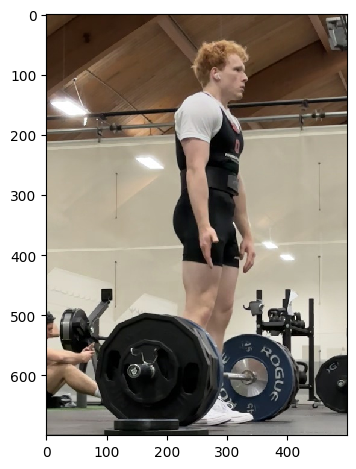

In [54]:
io.imshow(frames[0][500:1200, 500:1000])

In [56]:
fks = get_feature_vectors(frames[0][500:1200, 500:1000])

In [57]:
fks.shape

(700, 500, 5)

In [58]:
dists = compute_match_distances(fks, fks.shape, bar_template.shape, model_C)

0


/var/folders/w7/p5hccgr909d_v0mnz70pzwch0000gn/T/ipykernel_28180/3954995360.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  match_dist[i,j] = rho


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [139]:
dists_fast = compute_match_distances_fast(fks, (502,69), 20, bar_template.shape, model_C)

482


/var/folders/w7/p5hccgr909d_v0mnz70pzwch0000gn/T/ipykernel_28180/1561263223.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  match_dist[i-start[0],j-start[1]] = rho


483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521


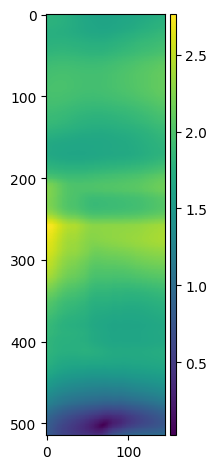

In [141]:
io.imshow(dists)

In [143]:
min_point = np.unravel_index(np.argmin(dists), dists.shape)
min_point

(502, 69)

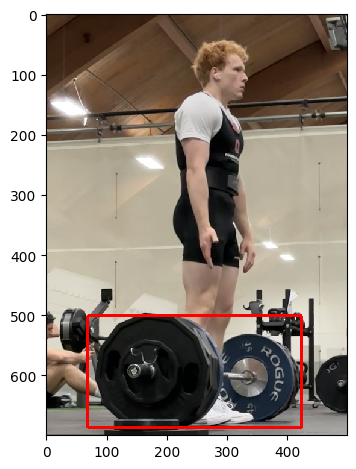

In [70]:
# note: I needed to flip the axes for the rectangle to display correctly
io.imshow(cv2.rectangle(frames[0][500:1200, 500:1000], (min_point[1], min_point[0]), (min_point[1] + 355 ,min_point[0] + 185), (255,0,0),3))

In [124]:
def blur(im, show=False, a=.4):
    w = [.25-.5*a, .25, a, .25, .25-.5*a]
    # make shape compatible with convolution
    w = np.resize(w, (5,5))
    
    # horizontal blur
    gxImR = scipy.ndimage.convolve(im[:,:,0], w, mode='nearest')
    gxImG = scipy.ndimage.convolve(im[:,:,1], w, mode='nearest')
    gxImB = scipy.ndimage.convolve(im[:,:,2], w, mode='nearest')

    # sample every other column
    sampled_colsR = gxImR[:,[x for x in range(0, gxImR.shape[1], 2)]]
    sampled_colsG = gxImG[:,[x for x in range(0, gxImG.shape[1], 2)]]
    sampled_colsB = gxImB[:,[x for x in range(0, gxImB.shape[1], 2)]]
    io.imshow(np.dstack((sampled_colsR, sampled_colsG, sampled_colsB)))
    
    # vertical blur
    gySampledR = scipy.ndimage.convolve(sampled_colsR, w.T, mode='nearest')
    gySampledG = scipy.ndimage.convolve(sampled_colsG, w.T, mode='nearest')
    gySampledB = scipy.ndimage.convolve(sampled_colsB, w.T, mode='nearest')
    
    # sample every other row
    blur_sampledR = gySampledR[[x for x in range(0, len(gySampledR), 2)],:]
    blur_sampledG = gySampledG[[x for x in range(0, len(gySampledG), 2)],:]
    blur_sampledB = gySampledB[[x for x in range(0, len(gySampledB), 2)],:]

    final = np.dstack((blur_sampledR, blur_sampledG, blur_sampledB))
    if show:
        plt.figure() ; io.imshow(final)
        print(final.shape)

    return final

In [126]:
def blur2(im, show=False, a=.4):
    w = [.25-.5*a, .25, a, .25, .25-.5*a]
    # make shape compatible with convolution
    w = np.resize(w, (5,5))
    
    # horizontal blur
    gxIm = scipy.ndimage.convolve(im, w, mode='nearest')
    
    # sample every other column
    sampled_cols = gxIm[:,[x for x in range(0, gxIm.shape[1], 2)]]
    # plt.figure() ; io.imshow(sampled_cols, cmap='gray')

    # vertical blur
    gySampled = scipy.ndimage.convolve(sampled_cols, w.T, mode='nearest')
    
    # sample every other row
    blur_sampled = gySampled[[x for x in range(0, len(gySampled), 2)],:]
    
    if show:
        plt.figure() ; io.imshow(blur_sampled, cmap='gray')
        print(blur_sampled.shape)

    return blur_sampled

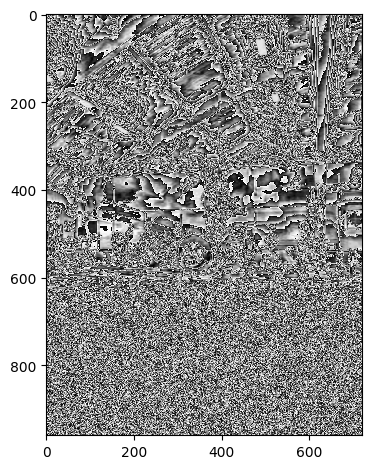

In [134]:
io.imshow(blur2(frames[1][:,:,0]))

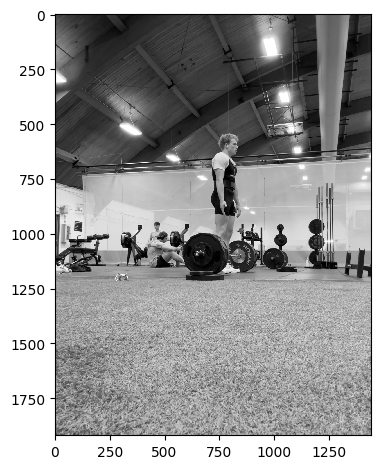

In [133]:
io.imshow(io.imread('./deadlift1/frame1.jpg', as_gray=True))

In [123]:
frames[1]

array([[[ 92,  64,  40],
        [ 92,  64,  40],
        [ 93,  66,  39],
        ...,
        [ 77,  55,  41],
        [ 76,  54,  40],
        [ 76,  54,  40]],

       [[ 93,  65,  41],
        [ 92,  64,  40],
        [ 93,  66,  39],
        ...,
        [ 78,  56,  42],
        [ 78,  56,  42],
        [ 78,  56,  42]],

       [[ 93,  65,  41],
        [ 92,  64,  40],
        [ 92,  65,  38],
        ...,
        [ 78,  56,  42],
        [ 78,  56,  42],
        [ 79,  57,  43]],

       ...,

       [[ 57,  80,  34],
        [ 47,  70,  24],
        [ 52,  75,  29],
        ...,
        [132, 156, 108],
        [131, 155, 107],
        [133, 157, 109]],

       [[ 53,  76,  32],
        [ 58,  81,  37],
        [ 40,  63,  19],
        ...,
        [138, 162, 114],
        [137, 161, 113],
        [136, 160, 112]],

       [[ 52,  75,  31],
        [ 44,  67,  23],
        [ 51,  74,  30],
        ...,
        [140, 164, 116],
        [132, 156, 108],
        [125, 149, 101]]